<!-- ![RWTH Logo](https://www.rwth-aachen.de/global/show_picture.asp?id=aaaaaaaaaaagazb) -->
![iAMB Logo](https://www.iamb.rwth-aachen.de/global/show_picture.asp?id=aaaaaaaaaanwtny)
# Calculations of Substrate and Production Rates and Yields
## Version: 0.2.0
* Execute a single cell: <span class="fa-play fa"></span>
* Execute all cells: Menu: Run <span class="fa-chevron-right fa"></span> Run All Cells
* To reboot kernel: <span class="fa-refresh fa"></span>

Find more in the reference (menu: Help <span class="fa-chevron-right fa"></span> Jupyter Reference).

This workflow takes growth experiments with complementary substrate concentrations as input and calculates growth and substrate uptake rates. For multiple growth experiments, the user manually stores the rate results of single experiments in a separate standardized Excel sheet to analyze global yields and maintenance cost. 

Additional resources:
 - [Verhulst logical growth equation](https://en.wikipedia.org/wiki/Logistic_function)
 

### Libraries
Loading required libraries for analysis.

 - Input:  None
 - Output: Text: `Libraries loaded.`

In [1]:
import os
import glob
import csv
import pandas as pd
import numpy as np
from datetime import date
from scipy import stats
from scipy.optimize import curve_fit
import ipywidgets as widgets

import matplotlib.pyplot as plt
%matplotlib inline

try:
    import iambcodes
except:
    print('update iambcodes')
    %pip install iambcodes
    import iambcodes
from iambcodes.rates import *

try:
    import openpyxl
except:
    print('update openpyxl')
    %pip install openpyxl
    import openpyxl

mol2g = {'glc':1/.18, 'glyc':1/.092, 'ace':1/.059, 'eg':1/.0621}
# All files are attached with the current date
Today = date.today().strftime('%y%m%d')
# print plus minus sign
pm = '\u00B1'

# update version tag from title
version = '0.1.0'
print('Libraries loaded.')

Libraries loaded.


## Data loading and variables setup

Evaluate the next cell and browse to your Excel sheet. Once evaluated, you can change the source Excel file arbitrarily.

 1. Use the standard format for growth experiments, example file [here](https://git.rwth-aachen.de/ulf.liebal/iambanalyses/-/blob/38cb8d35a01c865e78076217253ee73c4108b367/RatesYields/GrowthExperiment_StandardFormat.xlsx) 
 2. Upload your data in the standard format into the folder `Data/RatesYields`.
 3. Select the file in the browser. 
 
 - Input: Growth rate Excel Sheet
 - Output: None

In [2]:
# General Working Directory
# For automatic reading of directory, e.g. in cloud use:
Root_Dir = os.getcwd()
# remove the last directory fro Root_Dir
Root_Dir = os.path.dirname(Root_Dir)
Target_Dir = os.path.join(Root_Dir, 'Data', 'RatesYields')

File = 'GrowthExperiment_StandardFormat.xlsx' # Add Excel file with growth data
FileAddress = os.path.join(Target_Dir, File)
Xls_df = pd.ExcelFile(FileAddress)
print('Excel sheets:\n{}'.format(Xls_df.sheet_names))

# Output Files
# All files are attached with the current date
Today = date.today().strftime('%y%m%d')
# Choose image file type, e.g. svg, png, pdf, eps
ImageType = 'png'


Excel sheets:
['2229v1', 'Wierckx_50glc']



 ### Data selection

The sheet with the growth experiment can contain multiple data columns with variable names. The following cell allows you to select first the column for the biomass, and second the column for the substrate concentration. It is also possible to select multiple biomass or substrate concentration columns, if the mean and standard deviation should be used for analysis. Hold `Ctrl` while clicking on the corresponding sheet names. If no conversion factor for OD to gCDW is stored in the metadata of the sheet, you can set the factor.

 - Input:  Sheet names for biomass and substrate (single or multiple)
 - Ouptut: None

In [3]:
# Choosing Excel sheet
Sheet = '2229v1' 
# Define conversion factor, e.g. yeast: 0.62 (BNID 111182 in Bionumbers)

# Loading data from sheet into python, ignoring Metadata columns
df_orig = pd.read_excel(FileAddress, sheet_name=Sheet, usecols=lambda x: 'Metadata' not in x,)
df_orig = df_orig.dropna(how = 'all')
DelHeader = df_orig.columns[['Unnamed' in header for header in df_orig.columns]].values
df_orig = df_orig.drop(DelHeader, axis=1)

myMeta = pd.read_excel(FileAddress, sheet_name=Sheet, usecols=lambda x: 'Metadata' in x,)
TimeUnit = ''.join(myMeta.loc[myMeta['Metadata: Key']=='Time unit']['Metadata: Value'].values)
# add a biomass correction factor, e.g. from OD to gCDW, if none set to 1
BiomassUnit = ''.join(myMeta.loc[myMeta['Metadata: Key']=='Biomass unit']['Metadata: Value'].values)
if BiomassUnit == 'OD':
    ODConvert = True
    # read or define existing conversion factor for OD to gCDW/L
    BiomassCorr = myMeta.loc[myMeta['Metadata: Key']=='OD2CDW']['Metadata: Value'].values
    OD2DW = BiomassCorr if BiomassCorr.size > 0 else OD2DW
    BiomassUnit = 'gDW/L'
elif BiomassUnit == 'gDW/L':
    OD2DW = 1.
else:
    print('Use standard abbreviation for biomass unit: gDW/L, OD')
SubstrateUnit = ''.join(myMeta.loc[myMeta['Metadata: Key']=='Substrate unit']['Metadata: Value'].values)# 'mM'
# add a substrate correction factor, e.g. to convert from g/l to mM
SubstrateID = ''.join(myMeta.loc[myMeta['Metadata: Key']=='Substrate']['Metadata: Value'].values).lower()
# conversion of g/l concentration to mmol/l
SubstrateCorr = mol2g[SubstrateID] if SubstrateUnit=='g/L' else 1.
YieldCorr = 1/mol2g[SubstrateID]# if SubstrateUnit=='mM' else 1.

print('Data columns: {}'.format(list(df_orig.columns)))

Data columns: ['time', 'Biomass', 'Substrate']


## Data plotting

The following cells plots the data of biomass and substrate over time.

 - Input:  None
 - Output: 2x plot (biomass, substrate dynamics)

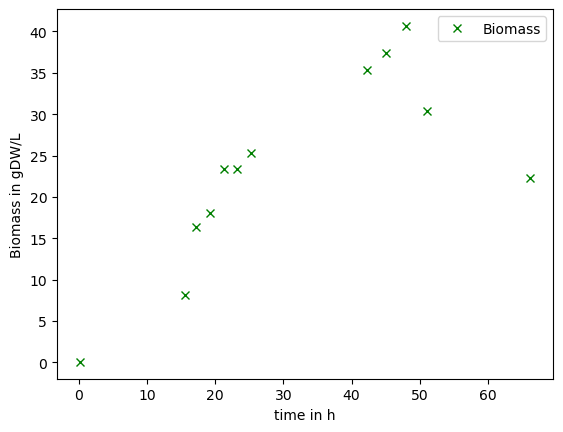

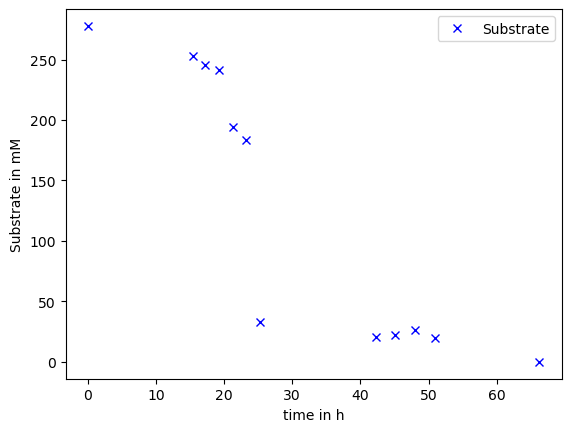

Index(['time', 'Biomass', 'Substrate'], dtype='object')


In [4]:
# Define the column names of biomass and substrate
# Use list input, e.g., ['Biomass'], for replicates ['Biomass1', 'Biomass2'], these will be combined 
BiomassID =  ['Biomass']
SubstrateID = ['Substrate']

df=df_orig.copy()

if len(BiomassID)>1:
    df['Biomass'] = np.mean(df_orig[BiomassID].values, axis=1)*OD2DW
    df['Biomass_std'] = np.std(df_orig[BiomassID].values, axis=1)*OD2DW
    # Biomass plot
    plt.errorbar(df['time'], df['Biomass'], df['Biomass_std'], label='Biomass')
    plt.xlabel('time in {}'.format(TimeUnit))
    plt.ylabel('Biomass in {}'.format(BiomassUnit))
    plt.legend()
    plt.show()
else:
    df['Biomass'] = df_orig[BiomassID]*OD2DW
    # Biomass plot
    plt.plot(df['time'], df_orig['Biomass'], 'xg', label='Biomass')
    plt.xlabel('time in {}'.format(TimeUnit))
    plt.ylabel('Biomass in {}'.format(BiomassUnit))
    plt.legend()
    plt.show()

if len(SubstrateID)>1:
    df['Substrate'] = np.mean(df_orig[SubstrateID].values, axis=1)*SubstrateCorr
    df['Substrate_std'] = np.std(df_orig[SubstrateID].values, axis=1)*SubstrateCorr
    # Substrate plot
    plt.errorbar(df['time'], df['Substrate'], df['Substrate_std'], label='Substrate')
    plt.xlabel('time in {}'.format(TimeUnit))
    plt.ylabel('Substrate in mM')
    plt.legend()
    plt.show()
else:
    df['Substrate'] = df_orig[SubstrateID]*SubstrateCorr
    # Substrate plot
    plt.plot(df['time'], df['Substrate'], 'xb', label='Substrate')
    plt.xlabel('time in {}'.format(TimeUnit))
    plt.ylabel('Substrate in mM')
    plt.legend()
    plt.show()
print(df.columns)

### Growth rate and substrate uptake rates

The following cell prepares the calculation of the rates. Choose the growth law and the time window for the analysis. The substrate uptake rate is calculated according to the material in the article by [Sato et al. 2016](https://doi.org/10.1371/journal.pgen.1006372) and the [S1](https://doi.org/10.1371/journal.pgen.1006372.s012) and [S2](https://doi.org/10.1371/journal.pgen.1006372.s013) Appendix.

 - Input: Growth law (linearized exponential, Verhulst logarithmic, exponential)
 - Output: Figure files in user format with estimation of growth and substrate rates

Growth rate: 0.23(±0.1) /h, with R2: 0.85
Substrate uptake: 2.96(±1.44) mmol/gCDW/h (check units), with R2: 0.82
Biomass yield: 0.43±0.28 gDW/g


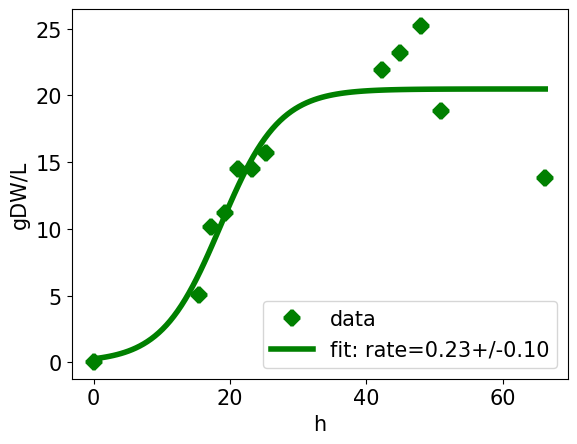

Growth rate fit figure saved as /home/ulf/Documents/2111_iambjudas/Data/RatesYields/231219_2229v1_log_GrowthFit.png


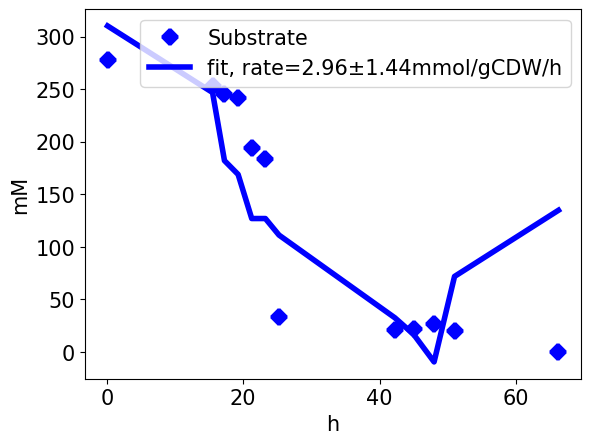

Substrate uptake fit figure saved as /home/ulf/Documents/2111_iambjudas/Data/RatesYields/231219_2229v1_log_SubFit.png


In [5]:
# Choose Growth Law
# Linearized Exponential: 'lex'
# Verhulst Logistic: 'log'
# Exponential: 'exp'
# Linear: 'lin'
BMLaw ='log'
# Enter the start and end times for exponential growth [1.5,8.6]:
ExpGrwth = [0,70]

inlog = False
if BMLaw == 'lex':
    inlog = True
    BMLaw = 'lin'
p0 = None # enter initial guesses for the logarithmic parameters here
fontsize = 15
plt.rc('font', size=fontsize)
kwargs = {'mew':10, 'lw':4}


FigureGrowth = '{}_{}_{}_GrowthFit.{}'.format(Today, Sheet, BMLaw, ImageType)
FigureGrowthPath = os.path.join(Target_Dir, FigureGrowth)
FigureSub = '{}_{}_{}_SubFit.{}'.format(Today, Sheet, BMLaw, ImageType)
FigureSubPath = os.path.join(Target_Dir, FigureSub)
# ExpGrwth = np.array(input('enter the start and end times for exponential growth [1.5,8.6]:').split(','), dtype=float)
ExpGrwth_ind = SubVector(ExpGrwth,df['time'].values)
Time = np.array(df['time'][ExpGrwth_ind]) # - df['time'][ExpGrwth_ind[0]]
Biomass = np.array(df['Biomass'][ExpGrwth_ind], dtype=float)
Substrate = np.array(df['Substrate'][ExpGrwth_ind])
                 
# Calculating growth rate
Bm_sl, Bm_sl_sterr, Bm_ic, Bm_lim = FitGrowth(Time, Biomass, law=BMLaw, inlog=inlog, p0=p0)

# Calculating substrate uptake rate
DeltaBm = np.array(df['Biomass'][ExpGrwth_ind]-df['Biomass'][ExpGrwth_ind[0]], dtype=float)
Sub_sl, Sub_ic, Sub_r, _, Sub_sl_sterr = stats.linregress(DeltaBm, Substrate)
SubUp = round(-Sub_sl*Bm_sl,2)
SubUp_sterr = round(SubUp*np.sqrt( (Sub_sl_sterr/Sub_sl)**2 + (Bm_sl_sterr/Bm_sl)**2 ), 2)

# r2 calculation
PlotPar = [Bm_sl, Bm_ic, Bm_lim] if BMLaw=='log' else [Bm_sl, Bm_ic]
r2_BM, _ = FitR2(Time, Biomass, PlotPar, law=BMLaw, inlog=inlog)
r2_Sub, _ = FitR2(Substrate, DeltaBm, [Sub_sl, Sub_ic], law='lin', inlog=False)

# yield calculation
Yield = round(Bm_sl,2) / (SubUp * YieldCorr) #round(Bm_sl,2)/(SubUp*YieldCorr[0])
# calculating the standard error of the yield based on gaussian error propagation
Yield_sterr = round(Yield*np.sqrt( (SubUp_sterr/SubUp)**2 + (Bm_sl_sterr/Bm_sl)**2 ), 2)

print(f'Growth rate: {round(Bm_sl,2)}({pm}{round(Bm_sl_sterr,2)}) /{TimeUnit}, with R2: {round(r2_BM,2)}')
print(f'Substrate uptake: {SubUp}({pm}{SubUp_sterr}) mmol/gCDW/h (check units), with R2: {round(abs(Sub_r),2)}')
print(f'Biomass yield: {round(Yield,2)}{pm}{Yield_sterr} gDW/g')

# Biomass plot
PlotFit(Time, Biomass, PlotPar, Bm_sl_sterr, [TimeUnit, BiomassUnit], law=BMLaw, inlog=inlog, export_file=FigureGrowthPath, kwargs=kwargs)
plt.show()
print('Growth rate fit figure saved as {}'.format(FigureGrowthPath))
# Substrate plot
plt.plot(df['time'], df['Substrate'], 'xb', label='Substrate', **kwargs)
plt.plot(df['time'][ExpGrwth_ind], Sub_ic+Sub_sl*DeltaBm, '-b', label=f'fit, rate={SubUp}{pm}{SubUp_sterr}mmol/gCDW/h', **kwargs)
plt.xlabel(TimeUnit)
plt.ylabel('mM')
plt.legend()
# plt.savefig(FigureSubPath)
plt.show()
print('Substrate uptake fit figure saved as {}'.format(FigureSubPath))




### Export parameters to configuration file

Here, the parameters for the analysis are exported into a text file. Most important are the file name, sheet name, names of the columns to be analyzed, biomass model for regression and regression time interval. If you store the information of the analysis elsewhere, you need not run the cell.

In [15]:
# Storing parameters in dictionary
# https://stackoverflow.com/questions/3972872/python-variables-as-keys-to-dict
Workflow = 'GrowthAnal'
ConfComment = '# This file contains the parameters used for growth and substrate rate analysis.'
loc=locals()
Par_Dict = {i: loc[i] for i in ('Workflow', 'version', 'Today', 'Target_Dir', 'File', 'ImageType', 'Sheet', 'OD2DW', 'BiomassID', 'SubstrateID', 'BMLaw', 'ExpGrwth')}

# constructing the config.txt file
ConfName = '{}_JUDAS-Growth_{}_{}_config.txt'.format(Today, os.path.splitext(File)[0], Sheet)
ConfAddress = os.path.join(Target_Dir, ConfName)
with open(ConfAddress, 'w') as f:
    print(ConfComment, file=f)
    for key, value in Par_Dict.items():
        print('{}: {}'.format(key, value), file=f)
print('Config file saved as {}'.format(ConfAddress))

Config file saved as /home/ulf/Documents/2111_iambjudas/Data/RatesYields/230928_JUDAS-Growth_GrowthExperiment_StandardFormat_2229v1_config.txt


## Calculation of growth rate sensitivity to substrate uptake

In [44]:
        
# General Working Directory
# For automatic reading of directory, e.g. in cloud use:
Target_Dir = os.path.join('..', 'Data', 'RatesYields')

File = 'RatesCompare_StandardFormat.xlsx'  # Add Excel file with growth data of multiple experiments
# Choose image file type, e.g. svg, png, pdf, eps
ImageType = 'svg'

FileAddress = os.path.join(Target_Dir, File)
Sheet = 'RateCompare' # Choose Excel sheet
RateComp = pd.read_excel(FileAddress, sheet_name=Sheet)
print('Data columns in Excel sheet:\n{}'.format(RateComp.columns))
print('Available growth experiments:\n{}'.format(RateComp['ID'].values))
# Output Files
# All files are attached with the current date
Today = date.today().strftime('%y%m%d')
# Figure files
FigureAccel = '{}_{}_GrowthVsSubRate.{}'.format(Today, os.path.splitext(os.path.split(File)[1])[0], ImageType)
FigureAccelPath = os.path.join(Target_Dir, FigureAccel)

InhibitCorrFig = '{}_{}_SubRateVSInitSub.{}'.format(Today, os.path.splitext(os.path.split(File)[1])[0], ImageType)
InhibitCorrPath = os.path.join(Target_Dir, InhibitCorrFig)

Data columns in Excel sheet:
Index(['ID', 'Comment', 'Tspan', 'BMLaw', 'Substrate', 'Rct-Name',
       'Initial Conc[g/L]', 'Growth-Rate[/h]', 'Growth-Std', 'R2-BM',
       'Substrate-uptake[mmol/gCDW/h]', 'Uptake-Std', 'R2-Sub', 'Yield[g/g]'],
      dtype='object')
Available growth experiments:
['2229v1' 'Wierckx_50glc']


Yield: 0.47 gCDW/g (+/-0.0) and R2: 0.9999999999999998
NGAM glucose requirement: 0.3 mmol/gCDW/h+/-0.0


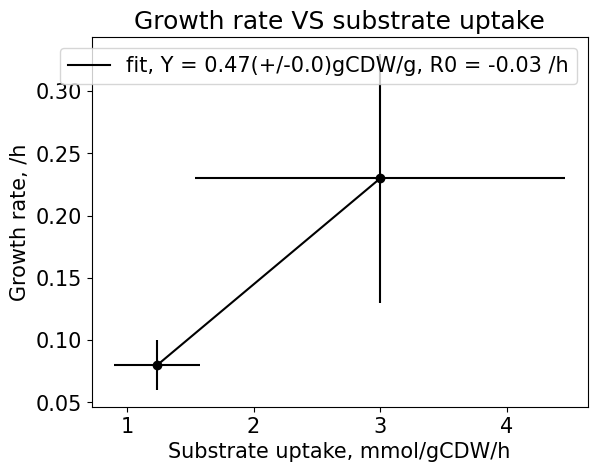

Growth rate versus substrate uptake figure saved as ../Data/RatesYields/231005_RatesCompare_StandardFormat_GrowthVsSubRate.svg


In [45]:
# Decide which substrate to examine, glucose: glc, glycerol: glyc, acetate: ace
SubType = 'glc'
SubUnit = 'mM'
SubstrateCorr =  [mol2g[SubType]  if SubUnit=='g/L' else 1.]
# Data rows to be ignored, list with names according to ID column e.g. [], or ['2229v1','Wierckx_50glc']
IgnoreDat = ['v1c']
# Define names of columns for analysis
GrowthMean = 'Growth-Rate[/h]'
GrowthStdv = 'Growth-Std'
SubstrMean = 'Substrate-uptake[mmol/gCDW/h]'
SubstrStdv = 'Uptake-Std'
SubstrInit = 'Initial Conc[g/L]'

# finding data rows with substrate to be checked
DelSub = RateComp[RateComp['Substrate'] != SubType].index
DelID = np.ravel([list(RateComp.index[IgnoreCheck == RateComp['ID']]) for IgnoreCheck in IgnoreDat])
DelRows = np.hstack([DelSub, DelID])

# ignoring any data points
if DelRows is not None:
    RateComp_corr = RateComp.drop(DelRows)
else:
    RateComp_corr = RateComp
    
GrowthVal = RateComp_corr[GrowthMean].values
SubVal = RateComp_corr[SubstrMean].values
GVstd =  RateComp_corr[GrowthStdv].values
SVstd = RateComp_corr[SubstrStdv].values

Yield, S0, r2, _, Yield_sterr = stats.linregress(SubVal, GrowthVal)
Yield_gg = round(Yield/.18,2)
Yield_sterr_gg = round(Yield_sterr/.18,2)
# calculation of NGAM via the substrate uptake at zero growth, 
# Growth = Yield*SubUp + Int -> Growth=0, then SubUp(Growth=0) = -Int / Yield
NGAM = round(-S0/Yield,2)
NGAM_std = round((-S0/(Yield-Yield_sterr) - -S0/(Yield+Yield_sterr))/2,2)
print('Yield: {} gCDW/g (+/-{}) and R2: {}'.format(Yield_gg, Yield_sterr_gg, r2))
print('NGAM glucose requirement: {} mmol/gCDW/h+/-{}'.format(NGAM, NGAM_std))
# Growth rate VS Substrate uptake plot
plt.errorbar(SubVal, GrowthVal, xerr=SVstd, yerr=GVstd, fmt='ok') #, 'xk', label='Substrate uptake'
plt.plot(SubVal, S0+Yield*SubVal, '-k', label='fit, Y = {}(+/-{})gCDW/g, R0 = {} /h'.format(Yield_gg, Yield_sterr_gg, round(S0,2)))
plt.title('Growth rate VS substrate uptake')
plt.xlabel('Substrate uptake, mmol/gCDW/h')
plt.ylabel('Growth rate, /h')
plt.legend()
plt.savefig(FigureAccelPath)
plt.show()
print('Growth rate versus substrate uptake figure saved as {}'.format(FigureAccelPath))


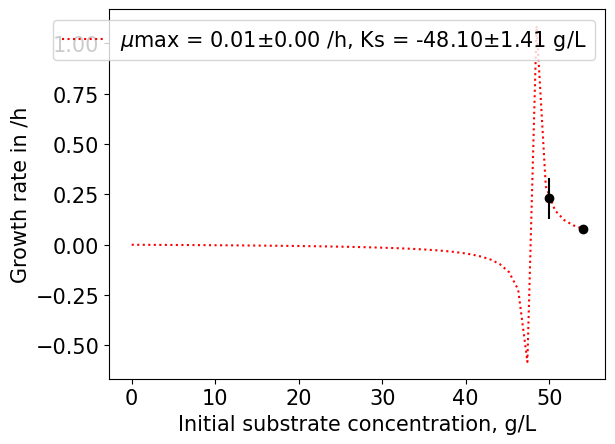

Growth rate versus substrate uptake figure saved as ../Data/RatesYields/231005_RatesCompare_StandardFormat_SubRateVSInitSub.svg


In [46]:
###############################
# Plot of initial substrate concentration versus substrate uptake rate
###############################
InitSub = RateComp_corr[SubstrInit].values
GrVal = RateComp_corr[GrowthMean].values # 
Grstd = RateComp_corr[GrowthStdv].values

# define michaelis menten equation with lambda
MiMe = lambda x, Vmax, Ks: Vmax * x / (Ks + x)

# curve fitting
popt, pcov = curve_fit(MiMe, InitSub, GrVal, sigma=GVstd, absolute_sigma=True)
perr = np.sqrt(np.diag(pcov))

# Estimate the parameters of the hyperbolic curve
Vmax = popt[0]
# standard deviation of the Vmax
Vmax_std = perr[0]

Ks = popt[1]
# standard deviation of the Km
Ks_std = perr[1]

# generating sample concentration values for the plot
x = np.linspace(0, np.max(InitSub), 50)
# Plot the transformed data and the fitted curve
plt.plot(x, MiMe(x, Vmax, Ks), ':r', label=f'$\mu$max = {Vmax:.2f}±{Vmax_std:.2f} /h, Ks = {Ks:.2f}±{Ks_std:.2f} g/L')


# Initial substrate concentration VS substrate uptake plot
plt.errorbar(InitSub, GrVal, yerr=GVstd, fmt='ok') #, 'xk', label='Substrate uptake'
plt.xlabel('Initial substrate concentration, g/L')
plt.ylabel('Growth rate in /h')
plt.legend()
plt.savefig(InhibitCorrPath)
plt.show()
print('Growth rate versus substrate uptake figure saved as {}'.format(InhibitCorrPath))

### Export parameters to configuration file

In [21]:
# Storing parameters in dictionary
# https://stackoverflow.com/questions/3972872/python-variables-as-keys-to-dict
loc=locals()
SaveParams = ['Workflow','Today', 'Target_Dir', 'File', 'Sheet', 'ImageType', 'SubType', 'SubUnit', 'IgnoreDat', 'GrowthMean', 'GrowthStdv', 'SubstrMean', 'SubstrStdv', 'SubstrInit']
Par_Dict = {i: loc[i] for i in SaveParams}
Workflow = 'RateComp'
# Comment for the config file
ConfComment = '# This file contains the parameters used for multi experiment comparison of growth and substrate rate analysis.'

# constructing the config.txt file
ConfName = '{}_JUDAS-RatesCompare_{}_config.txt'.format(Today, os.path.splitext(File)[0])
ConfAddress = os.path.join(Target_Dir, ConfName)
with open(ConfAddress, 'w') as f:
    print(ConfComment, file=f)
    for key, value in Par_Dict.items():
        print('{}: {}'.format(key, value), file=f)
print('User parameters stored in: {}'.format(ConfAddress))

User parameters stored in: ../Data/RatesYields/230928_JUDAS-RatesCompare_RatesCompare_StandardFormat_config.txt
